# Projekt założenia
symulator zdarzeniowy M/M/1/N
    - średni czas oczekiwania na obsługę
    - prawdopobieństwo blokady
porównać zmodelem analitycznym:
    - dla N = 51
    - różnych wartości obciążenia: 0.01, 0.05, 0.1

średni czas oczekiwania - > histogram


In [21]:
# https://pyshark.com/poisson-distribution-and-poisson-process-in-python/#poisson-distribution-example-in-python
import scipy
import numpy as np
import matplotlib
from enum import Enum
import uuid

czas w serwerze to jest "usługa" 

In [22]:
import math
# global_time = 0
n = 51 # max order in a system
# zmienna lososowa opisująca czas między zgłoszeniami
la = 0.99 # 1.0478 # 0.977 #  # intensywność napływu
# time_between_packet = 1 / la
# zmienna losowa opisuje czas pomiędzy zgłoszeniami k przez serwer
mu = 1
# time_of_service = 1 / mu # intensywność obsługi
time_of_simulation = 25
seed_val =1

# https://github.com/amasl2048/queue-mm1/blob/master/qtest.cpp
roh = la / mu
rn = pow(roh, n + 1)
p0 = (1 - roh) / (1 - rn)         # free queue probability
pb = p0 * rn / roh                

navg = roh / (1-roh) - (n+1) * rn/(1-rn)  
tavg = navg / la                    
u    = mu * (1 - p0)                

out = '''
pb   = %.4f    # block probability
navg = %.4f    # average orders in a system
tavg = %.4f    # average time in a system
u    = %.4f    # throughput
'''
print(out % (pb, navg, tavg, u))

avr_queue = (roh * (1 + roh ** n * (n * roh - (n + 1))))/ (mu * ( 1 - roh) * (1 - roh * (roh ** (n+2))))
print(f"average time in queue: {avr_queue}")
problock = roh ** (n + 1) * ( 1 - roh) / (1 - roh ** (n + 2))
print(f"probability of block: {problock}")


pb   = 0.0147    # block probability
navg = 23.2464    # average orders in a system
tavg = 23.4812    # average time in a system
u    = 0.9754    # throughput

average time in queue: 22.591470484513554
probability of block: 0.014358819877070383


In [23]:
class EventType(Enum):
    IN_EVENT = "IN_EVENT"
    OUT_EVENT = "OUT_EVENT"

# slajd 91, 

class Event():
    def __init__(self, time: float, event_type, client_id = None):
        self.time = time
        self.event_type = event_type
        if client_id == None:
            self.client_id = str(uuid.uuid4())
        else:
            self.client_id = client_id
    
    def __str__(self):
        mes = f"{self.client_id}, {self.event_type}, {self.time}"
        return mes
    
    def set_time_in_queue(self, time_in_queue):
        self.time_in_queue = time_in_queue
    
    def get_event_stats(self):
        return {
            'oc_time': self.time,
            # 'qu_time': self.time_in_queue,
            'client_id': self.client_id,
            'event_type': self.event_type
        }

In [24]:
class Server:
    def __init__(self):
        self.all_clients =0 
        self.all_clients_in_queue = 0
        self.client_in_server = False
        self.clients_number_in_queue = 0 
        self.client_in_server = None
        self.clients_in_queue = []
        self.buffor = n
    
    def get_server_stats(self):
        return self.client_in_server, self.clients_number_in_queue

    def is_server_empty(self):
        return not self.client_in_server

    def is_queue_empty(self):
        return not self.clients_in_queue

    def is_place_for_new_event(self):
        return self.clients_number_in_queue + 1 <= self.buffor

    def add_client_to_server(self, client_id, timestamp):
        self.all_clients += 1
        self.client_in_server = True
        self.clients_in_server = (client_id, timestamp)

    def add_client_to_queue(self, client_id, timestamp):
        self.all_clients_in_queue += 1
        self.clients_number_in_queue += 1
        self.clients_in_queue.insert(0, (client_id, timestamp))

    def get_queue_first_client(self):
        return self.clients_in_queue[-1]

    """
    def delete_client_from_queue(self):
        self.clients_number_in_queue -= 1
        self.clients_in_queue.pop(0)
    
    """
    def delete_client_from_queue(self, client_id):
        self.clients_number_in_queue -= 1
        self.clients_in_queue = list(
            filter(
                lambda client: client[0] != client_id,
                self.clients_in_queue))
    
    def delete_client_from_server(self):
        self.client_in_server = False
        self.client_in_server = None




In [25]:
class Simulation:
    def __init__(self):
        # marge
        self.events = []
        self.clients_stats = []
        self.all_events = []
        self.server = Server()
        self.clients = 0 
        self.current_time = 0 


    def handle_events(self):
        i = 1
        while self.events:
            current_event = self.events.pop()
            current_time = current_event.time
            # print(f"current event: {current_event}")
            # print(self.server.is_place_for_new_event())
            # print(current_event, self.server.clients_in_queue, not self.server.is_queue_empty())
            # print(len(self.events))
            # check buffor, time in queue
            if current_event.event_type == EventType.IN_EVENT:
                if self.server.is_server_empty():
                    self.server.add_client_to_server(current_event.client_id, current_time)
                    self.events.append(Event(current_time + self.expotential_value(mu),  EventType.OUT_EVENT, current_event.client_id))
                    # print("event in server") 
                    # print(current_time + self.expotential_value(mu))
                else:
                    if self.server.is_place_for_new_event():
                       #  print("event added to queue")
                        self.server.add_client_to_queue(current_event.client_id, current_time)
                    else:
                        #  print("packet dropped")
                        pass
                       
            if current_event.event_type == EventType.OUT_EVENT:
                self.server.delete_client_from_server()
                self.clients -= 1
                time_in_server = self.expotential_value(mu)
                # print(time_in_server)
                if not self.server.is_queue_empty():
                    # print("Server bussy")
                    # print(self.server.get_queue_first_client())
                    client_id, client_time = self.server.get_queue_first_client()
                    self.server.delete_client_from_queue(client_id)
                    new_event = Event(current_time + time_in_server, EventType.OUT_EVENT, client_id=client_id)
                    new_event.set_time_in_queue(current_time - client_time)
                    self.events.append(new_event)
                    self.clients_stats.append(new_event.time_in_queue)
            self.events = self.sort_events()
            """
            print(f"interation: {i}")
            i += 1
            for event in self.events:
                print(event)
            """
    def init_events(self):
        occurrence_time = 0
        while occurrence_time < time_of_simulation:
            event_occurance = self.expotential_value(la)
            occurrence_time += event_occurance
            new_event = Event(
                occurrence_time,
                EventType.IN_EVENT
                )
            # print(new_event.time, occurrence_time )
            self.events.append(new_event)
        self.events = self.sort_events()
        self.clients = len(self.events)
        """
        print(f"interation: 0")
        for event in self.events:
            print(event)
        """
    def run_simulation(self):
        self.init_events()
        self.handle_events()
    
    def expotential_value(self, lambda_value):
        wojtek = 1 - np.random.random()
        return -1 * (np.log(wojtek) / lambda_value)
    """
    def generate_interarrival(self):
        return np.random.exponential(la)
    
    def generate_service(self):
        return np.random.exponential(mu)
    """
    def sort_events(self):
        return sorted(
                self.events,
                key=lambda time: getattr(time, 'time'),
                reverse= True)
# sim = Simulation()
# sim.run_simulation()

In [26]:
# statistics
np.random.seed(seed_val)
sim = Simulation()
sim.run_simulation()
"""
# print(sim.clients)
all_time_in_queue = 0
pakiets_in_queue = 0
for idx,  time_in_queue in enumerate(sim.clients_stats):
    # print(time_in_queue)
    all_time_in_queue += time_in_queue
    pakiets_in_queue += 1
all_time_in_queue/pakiets_in_queue
"""

1.9486493601053547

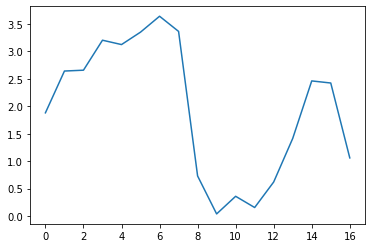

In [27]:
import matplotlib.pyplot as plt
plt.plot(sim.clients_stats)

get pobiera zdarzenie z listy z namnijeszym czasem, przesuwa czas symulacji do tego czasu

To do: 
- czy ten exmpnetial jest dobry aby na pewno to possion? 
- zrobić historgram dla b
- sprawko 
- wysłać

UAKTUALNIENIE: ponieważ w punkcie III projektu wkradł się błąd a jest już blisko terminu oddania prac, proszę wykonać tę część przy prostym założeniu, że odstęp miedzy przychodzącymi klientami jest stały i równy średniej z punktu I. 
Reference materials